In [2]:
import sys
path_root = 'E:\\DataLoader'
sys.path.append(str(path_root))

import dataset.coco as dataset

In [2]:
import json
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Rectangle

import torch
import torch.utils.data as torch_data

In [3]:
def load_ann(path):
    ann = []
    with open(path) as f:
        ann = json.load(f)
    return ann

def load_img(path, name):
    img = cv2.imread(os.path.join(path, name))
    return img

def show_img(img, ann=None):
    fig, ax = plt.subplots(1,1, figsize=(15,8))
    ax.imshow(img)
    patches = []
    r = 3
    lw = 3
    if ann:

        for a in ann:
            bbox = a['bbox']
            patches.append(Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], color='red', linewidth=lw, fill=False))
        
            kp = a['keypoints']
            for i in range(0, len(kp), 3):
                if kp[i+2] > 0:
                    patches.append(Circle((kp[i], kp[i+1]), radius=r, color='red'))
            
            
            
        for p in patches:
            ax.add_patch(p)
        
def get_iid_to_ann(ann):
    iid_to_ann = {}

    for a in ann['images']:
        iid_to_ann[a['id']] = []
    for a in val_ann['images']:
        iid_to_ann[a['id']] = []   

    for a in ann['annotations']:
        iid_to_ann[a['image_id']].append(a)    
    for a in val_ann['annotations']:
        iid_to_ann[a['image_id']].append(a)
        
    return iid_to_ann

In [4]:
images_path = 'coco_tiny/images'
train_ann_path = 'coco_tiny/train_full.json'
val_ann_path = 'coco_tiny/val_full.json'

train_ann = load_ann(train_ann_path)
val_ann = load_ann(val_ann_path)

In [5]:
train_ann['images'][0]

{'license': 6,
 'file_name': '000000271177.jpg',
 'coco_url': 'http://images.cocodataset.org/train2017/000000271177.jpg',
 'height': 500,
 'width': 375,
 'date_captured': '2013-11-15 14:35:03',
 'flickr_url': 'http://farm2.staticflickr.com/1337/1360004143_fcf8aaad45_z.jpg',
 'id': 271177}

In [6]:
iid_to_ann = get_iid_to_ann(train_ann)

In [7]:



    
def get_affine_transform(center,
                         scale,
                         rot,
                         output_size,
                         shift=np.array([0, 0], dtype=np.float32),
                         inv=0):
    
    if not isinstance(scale, np.ndarray) and not isinstance(scale, list):
        print(scale)
        scale = np.array([scale, scale])

    scale_tmp = scale * 200.0
    src_w = scale_tmp[0]
    dst_w = output_size[0]
    dst_h = output_size[1]

    rot_rad = np.pi * rot / 180
    src_dir = get_dir([0, src_w * -0.5], rot_rad)
    dst_dir = np.array([0, dst_w * -0.5], np.float32)

    src = np.zeros((3, 2), dtype=np.float32)
    dst = np.zeros((3, 2), dtype=np.float32)
    src[0, :] = center + scale_tmp * shift
    src[1, :] = center + src_dir + scale_tmp * shift
    dst[0, :] = [dst_w * 0.5, dst_h * 0.5]
    dst[1, :] = np.array([dst_w * 0.5, dst_h * 0.5]) + dst_dir

    src[2:, :] = get_3rd_point(src[0, :], src[1, :])
    dst[2:, :] = get_3rd_point(dst[0, :], dst[1, :])

    if inv:
        trans = cv2.getAffineTransform(np.float32(dst), np.float32(src))
    else:
        trans = cv2.getAffineTransform(np.float32(src), np.float32(dst))

    return trans


def affine_transform(pt, t):
    new_pt = np.array([pt[0], pt[1], 1.]).T
    new_pt = np.dot(t, new_pt)
    return new_pt[:2]


def get_3rd_point(a, b):
    direct = a - b
    return b + np.array([-direct[1], direct[0]], dtype=np.float32)

def get_dir(src_point, rot_rad):
    sn, cs = np.sin(rot_rad), np.cos(rot_rad)

    src_result = [0, 0]
    src_result[0] = src_point[0] * cs - src_point[1] * sn
    src_result[1] = src_point[0] * sn + src_point[1] * cs

    return src_result

In [8]:
class COCODataset(torch_data.Dataset):
    def __init__(self, dataset_filename, img_path):
        dataset_ann = load_ann(dataset_filename)
        self.pixel_std = 200
        self.image_width = 192
        self.image_height = 256
        self.image_size = (self.image_width, self.image_height)
        self.aspect_ratio = self.image_width * 1.0 / self.image_height
        self.data = []
        
        iid_to_ann = get_iid_to_ann(dataset_ann)
        
        h = 256
        w = 192
        for img in dataset_ann["images"]:
            iid = img['id']
            anns = iid_to_ann[iid]
            for ann in anns:
                if ann['num_keypoints'] > 0:
                    data = ann
                    crop_box = ann['bbox'] # fcn to crop in size hxw
                    center, scale = self._box2cs(ann['bbox'])
                    data['crop_box'] = crop_box
                    data['file_path'] = os.path.join(img_path, img['file_name'])
                    data['center'] = center
                    data['scale'] = scale
                    #data['image_size'] = (img['width'], img['height'])
                    self.data.append(data)
                    
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        data = self.data[idx]
        img = cv2.imread(data['file_path'])
        img = img[:,:,::-1]
        c = data['center']
        s = data['scale']
        r = 0
        
        trans = get_affine_transform(c, s, r, self.image_size)
        
        img_inp = cv2.warpAffine(
            img,
            trans,
            (int(self.image_size[0]), int(self.image_size[1])),
            flags=cv2.INTER_LINEAR)
        
        return img_inp
    
    
    

    def _box2cs(self, box):
        x, y, w, h = box[:4]
        return self._xywh2cs(x, y, w, h)

    def _xywh2cs(self, x, y, w, h):
        center = np.zeros((2), dtype=np.float32)
        center[0] = x + w * 0.5
        center[1] = y + h * 0.5

        if w > self.aspect_ratio * h:
            h = w * 1.0 / self.aspect_ratio
        elif w < self.aspect_ratio * h:
            w = h * self.aspect_ratio
        scale = np.array(
            [w * 1.0 / self.pixel_std, h * 1.0 / self.pixel_std],
            dtype=np.float32)
        if center[0] != -1:
            scale = scale * 1.25

        return center, scale

In [9]:
data_loader = COCODataset(train_ann_path, images_path)

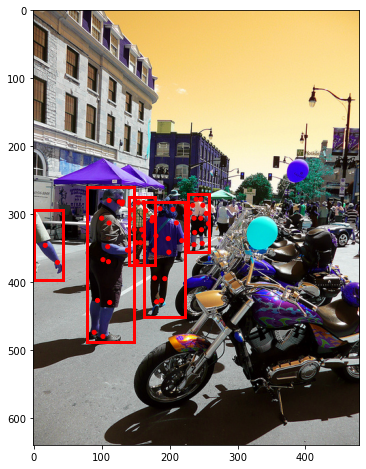

In [179]:
for i in range(len(train_ann['images'])):
    if train_ann['images'][i]['id'] == 332221:
        img_name = train_ann['images'][i]['file_name']
        imid = train_ann['images'][i]['id']
        img = load_img(images_path, img_name)
        annots = iid_to_ann[imid]
        show_img(img, annots)
    

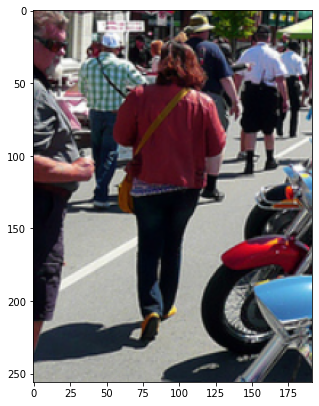

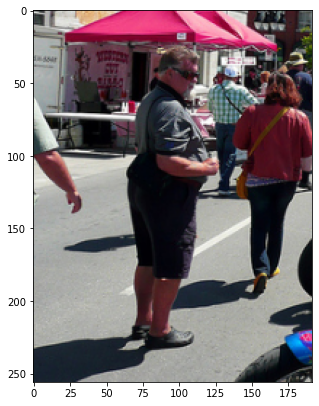

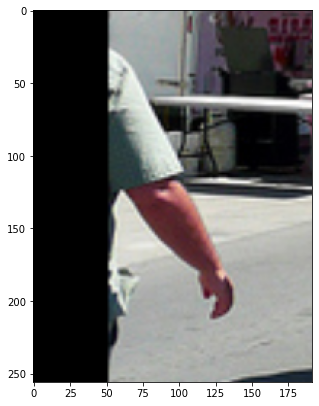

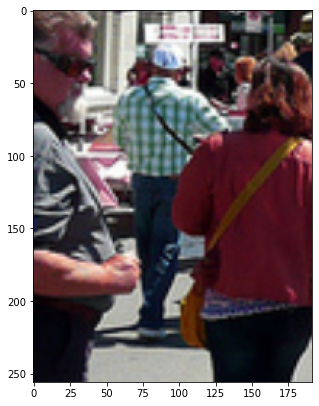

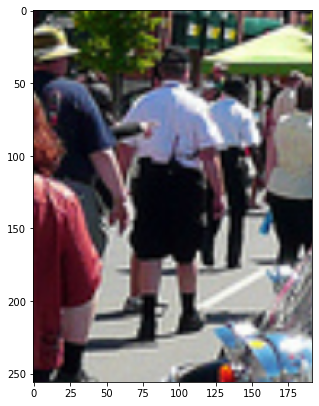

In [177]:
for i in range(5, 10):
    fig, ax = plt.subplots(figsize=(5,7))
    ax.imshow(data_loader[i])


In [ ]:
for i in range(len(train_ann['images'])):
    img_name = train_ann['images'][i]['file_name']
    imid = train_ann['images'][i]['id']
    img = load_img(images_path, img_name)
    annots = iid_to_ann[imid]
    show_img(img, annots)

In [72]:
"""
names = []
for i in range(len(train_ann)):
    img_name = train_ann[i]['image_file']
    if img_name in names:
        print(img_name, '- idx :', i)
    else:
        names.append(img_name)
        
coco_train_ann = "E:/Datasets/COCO/annotations/person_keypoints_train2017.json"
coco_train = load_ann(coco_train_ann)

full_train_ann = {'images' : [], 'annotations' : []}
img_ids = []

for a in coco_train['images']:
    name = a['file_name']
    if name in names:
        full_train_ann['images'].append(a)
        img_ids.append(a['id'])
        


for a in coco_train['annotations']:
    iid = a['image_id']
    if iid in img_ids and a['num_keypoints'] > 0:
        full_train_ann['annotations'].append(a)
        
with open('coco_tiny/train_full.json', 'w') as outfile:
    json.dump(full_train_ann, outfile)
"""

000000254919.jpg - idx : 44
000000057703.jpg - idx : 64


In [73]:
"""
names = []
for i in range(len(val_ann)):
    img_name = val_ann[i]['image_file']
    if img_name in names:
        print(img_name, '- idx :', i)
    else:
        names.append(img_name)

coco_val_ann = "E:/Datasets/COCO/annotations/person_keypoints_train2017.json"
coco_val = load_ann(coco_val_ann)

full_val_ann = {'images' : [], 'annotations' : []}
img_ids = []

for a in coco_val['images']:
    name = a['file_name']
    if name in names:
        full_val_ann['images'].append(a)
        img_ids.append(a['id'])
        


for a in coco_val['annotations']:
    iid = a['image_id']
    if iid in img_ids and a['num_keypoints'] > 0:
        full_val_ann['annotations'].append(a)
        
with open('coco_tiny/val_full.json', 'w') as outfile:
    json.dump(full_val_ann, outfile)
"""

000000515289.jpg - idx : 15
